# Get center vector

In [12]:
import pandas as pd
import numpy as np
import json

df = pd.read_excel("/home/tuananh/tuananh/domain_calibration/experiments/resnet_34_kfold_val_outdomain_logits.xlsx")
domain_name = "amazon"
df = df[df.domain_name == domain_name]
df = df[df.phase == "train"]


In [13]:
train_logit = np.vstack([json.loads(x) for x in df["logit"].values])
train_logit.shape

(1878, 31)

## Get mean vector

In [14]:
# import torch
# from torch.utils.data import DataLoader

# def default_collate(batch):
#     batch = list(filter(lambda x: x is not None, batch))
#     data_chest_cls = torch.stack([torch.tensor(item[0]) for item in batch])
#     data_paths = [item[1] for item in batch]
    
#     return data_chest_cls, data_paths

# class Dataset(torch.utils.data.Dataset):
#     def __init__(self, image_paths):
#         self.image_paths = image_paths

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, index):
#         path = self.image_paths[index]
#         image = np.array(Image.open(path).convert('RGB').resize((224, 224)))

#         return image, path

# params = {'batch_size': 100,
#           'shuffle': True,
#           'num_workers': 6}

# data_set = Dataset(path_source)
# data_generator = torch.utils.data.DataLoader(data_set, collate_fn=default_collate, **params)

# def batch_mean(loader):
#     nimages = 0
#     mean = 0.
#     for batch, path in tqdm(loader):
#         batch = batch.permute(0, 3, 1, 2).float()
#         # Rearrange batch to be the shape of [B, C, W * H]
#         batch = batch.view(batch.size(0), batch.size(1), -1)
#         # Update total number of images
#         nimages += batch.size(0)
#         # Compute mean and std here
#         mean += batch.mean(2).sum(0)
#     mean /= nimages

#     return mean

# mean = batch_mean(data_generator)
# print("mean: \n", mean)

## Get mean feature

In [35]:
df = pd.read_excel("/home/tuananh/Downloads/resnet_34_export_feature_vector.xlsx")
df

,Unnamed: 0,imageid,classes,kfold,domain_name,feature_vector,mean_feature_vector,phase
0,2439,speaker__frame_0060.jpg,27,2,amazon,"[0.7866790890693665, 0.4095028042793274, 0.434...","[0.8678568601608276, 0.9047098755836487, 0.974...",train
1,1470,mobile_phone__frame_0020.jpg,14,1,amazon,"[0.24084703624248505, 0.14437007904052734, 0.0...","[0.8678568601608276, 0.9047098755836487, 0.974...",train
2,1504,ring_binder__frame_0041.jpg,24,1,amazon,"[2.546351432800293, 0.13088613748550415, 2.884...","[0.8678568601608276, 0.9047098755836487, 0.974...",train
3,1695,desk_lamp__frame_0058.jpg,7,1,amazon,"[0.17117846012115479, 0.4135337173938751, 0.13...","[0.8678568601608276, 0.9047098755836487, 0.974...",train
4,1344,ruler__frame_0055.jpg,25,1,amazon,"[3.187462568283081, 0.8898496031761169, 1.1747...","[0.8678568601608276, 0.9047098755836487, 0.974...",train
...,...,...,...,...,...,...,...,...
1873,2124,letter_tray__frame_0088.jpg,13,2,amazon,"[3.686697006225586, 0.5890908241271973, 1.8841...","[0.8678568601608276, 0.9047098755836487, 0.974...",train
1874,1110,desktop_computer__frame_0058.jpg,8,1,amazon,"[0.8258359432220459, 0.10587628185749054, 1.19...","[0.8678568601608276, 0.9047098755836487, 0.974...",train
1875,1847,back_pack__frame_0051.jpg,0,2,amazon,"[0.10528437793254852, 1.3962713479995728, 0.08...","[0.8678568601608276, 0.9047098755836487, 0.974...",train
1876,1211,mug__frame_0053.jpg,17,1,amazon,"[0.8450160026550293, 0.02065606229007244, 0.06...","[0.8678568601608276, 0.9047098755836487, 0.974...",train


In [51]:
dictionary_dist = {}
pdist = torch.nn.PairwiseDistance(p=2)

for index, row in df.iterrows():
    mean_feature_vector = torch.tensor(json.loads(df.iloc[0]["mean_feature_vector"]))
    feature_vector = torch.tensor(json.loads(row["feature_vector"]))
    pdist = torch.nn.PairwiseDistance(p=2)
    dist = pdist(feature_vector.view(1, -1), mean_feature_vector.cpu().view(1, -1))
    dictionary_dist[row["imageid"]] = dist.cpu().numpy()[0]

In [59]:
sorted_dictionary_dists = {k: str(v) for k, v in sorted(dictionary_dist.items(), key=lambda item: item[1])}
image_id_closest = list(sorted_dictionary_dists.keys())[0]

In [60]:
image_id_closest

'monitor__frame_0031.jpg'

In [43]:
import torch
import numpy as np

def extract_ampl_phase(fft_im):
    # fft_im: size should be bx3xhxwx2
    fft_amp = fft_im[:,:,:,:,0]**2 + fft_im[:,:,:,:,1]**2
    fft_amp = torch.sqrt(fft_amp)
    fft_pha = torch.atan2( fft_im[:,:,:,:,1], fft_im[:,:,:,:,0] )
    return fft_amp, fft_pha

def low_freq_mutate( amp_src, amp_trg, L=0.1 ):
    _, _, h, w = amp_src.size()
    b = (  np.floor(np.amin((h,w))*L)  ).astype(int)     # get b
    amp_src[:,:,0:b,0:b]     = amp_trg[:,:,0:b,0:b]      # top left
    amp_src[:,:,0:b,w-b:w]   = amp_trg[:,:,0:b,w-b:w]    # top right
    amp_src[:,:,h-b:h,0:b]   = amp_trg[:,:,h-b:h,0:b]    # bottom left
    amp_src[:,:,h-b:h,w-b:w] = amp_trg[:,:,h-b:h,w-b:w]  # bottom right
    return amp_src

def low_freq_mutate_np( amp_src, amp_trg, L=0.1 ):
    a_src = np.fft.fftshift( amp_src, axes=(-2, -1) )
    a_trg = np.fft.fftshift( amp_trg, axes=(-2, -1) )

    _, h, w = a_src.shape
    b = (  np.floor(np.amin((h,w))*L)  ).astype(int)
    c_h = np.floor(h/2.0).astype(int)
    c_w = np.floor(w/2.0).astype(int)

    h1 = c_h-b
    h2 = c_h+b+1
    w1 = c_w-b
    w2 = c_w+b+1

    a_src[:,h1:h2,w1:w2] = a_trg[:,h1:h2,w1:w2]
    a_src = np.fft.ifftshift( a_src, axes=(-2, -1) )
    return a_src

def FDA_source_to_target(src_img, trg_img, L=0.1):
    # exchange magnitude
    # input: src_img, trg_img

    # get fft of both source and target
    fft_src = torch.rfft( src_img.clone(), signal_ndim=2, onesided=False ) 
    fft_trg = torch.rfft( trg_img.clone(), signal_ndim=2, onesided=False )

    # extract amplitude and phase of both ffts
    amp_src, pha_src = extract_ampl_phase( fft_src.clone())
    amp_trg, pha_trg = extract_ampl_phase( fft_trg.clone())

    # replace the low frequency amplitude part of source with that from target
    amp_src_ = low_freq_mutate( amp_src.clone(), amp_trg.clone(), L=L )

    # recompose fft of source
    fft_src_ = torch.zeros( fft_src.size(), dtype=torch.float )
    fft_src_[:,:,:,:,0] = torch.cos(pha_src.clone()) * amp_src_.clone()
    fft_src_[:,:,:,:,1] = torch.sin(pha_src.clone()) * amp_src_.clone()

    # get the recomposed image: source content, target style
    _, _, imgH, imgW = src_img.size()
    src_in_trg = torch.irfft( fft_src_, signal_ndim=2, onesided=False, signal_sizes=[imgH,imgW] )

    return src_in_trg

def FDA_source_to_target_np( src_img, trg_img, L=0.1 ):
    # exchange magnitude
    # input: src_img, trg_img

    src_img_np = src_img #.cpu().numpy()
    trg_img_np = trg_img #.cpu().numpy()

    # get fft of both source and target
    fft_src_np = np.fft.fft2( src_img_np, axes=(-2, -1) )
    fft_trg_np = np.fft.fft2( trg_img_np, axes=(-2, -1) )

    # extract amplitude and phase of both ffts
    amp_src, pha_src = np.abs(fft_src_np), np.angle(fft_src_np)
    amp_trg, pha_trg = np.abs(fft_trg_np), np.angle(fft_trg_np)

    # mutate the amplitude part of source with target
    amp_src_ = low_freq_mutate_np( amp_src, amp_trg, L=L )

    # mutated fft of source
    fft_src_ = amp_src_ * np.exp( 1j * pha_src )

    # get the mutated image
    src_in_trg = np.fft.ifft2( fft_src_, axes=(-2, -1) )
    src_in_trg = np.real(src_in_trg)

    return src_in_trg


## Visualize image

In [88]:
import numpy as np
from PIL import Image
import scipy.misc
import cv2

im_src = cv2.imread("/Users/tuananh/tuananh/domain_calibration/experiments/visualize_img/Office/dslr/dslr_fold0.jpeg")
im_trg = cv2.imread("/Users/tuananh/tuananh/domain_calibration/experiments/visualize_img/Office/dslr/webcam_fold0.jpeg")

im_src = cv2.resize(im_src, (224,224), interpolation = cv2.INTER_AREA)
im_trg = cv2.resize(im_trg, (224,224), interpolation = cv2.INTER_AREA)

src_in_trg = FDA_source_to_target_np(im_trg, im_src, L=0.001)

# src_in_trg = src_in_trg.transpose((1,2,0))

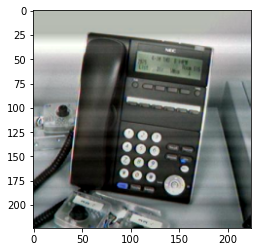

In [89]:
import matplotlib.pyplot as plt

image = np.array(np.clip(src_in_trg, 0.0, 255.0), np.int32)
plt.imshow(image)

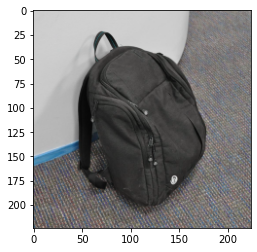

In [90]:
plt.imshow(im_src)

/var/folders/l9/_z6fsszd7rz5pg4v1jmq2jvh0000gn/T/ipykernel_58700/461287944.py:36: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


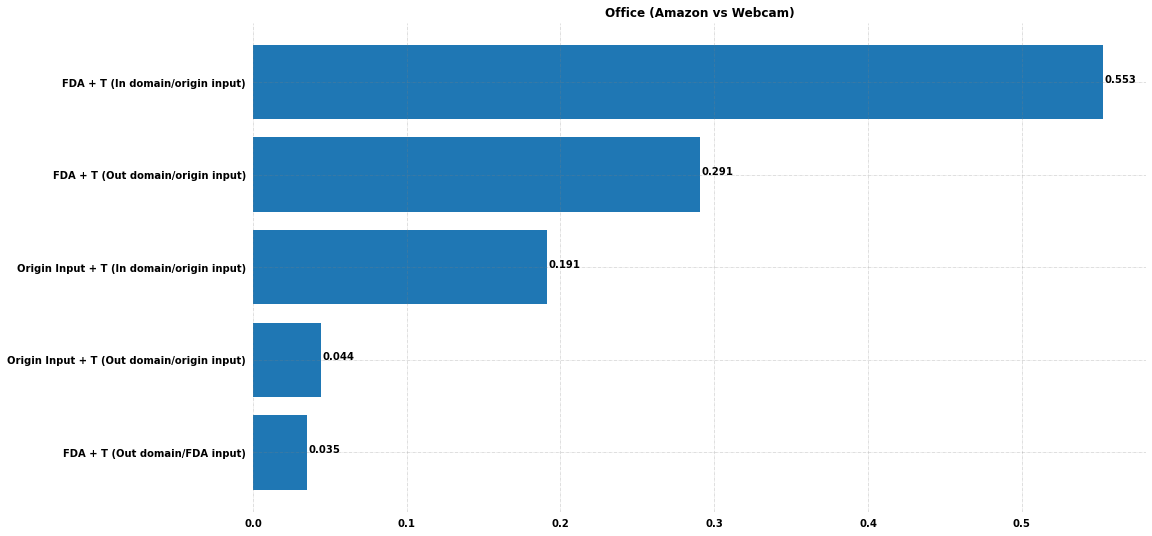

In [177]:
import pandas as pd
from matplotlib import pyplot as plt

name = [
    "FDA + T (In domain/origin input)",
    "FDA + T (Out domain/origin input)",
    "Origin Input + T (In domain/origin input)",
    "Origin Input + T (Out domain/origin input)",
    "FDA + T (Out domain/FDA input)",
]
price = [0.553, 0.291, 0.191, 0.044, 0.035]

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))

# Horizontal Bar Plot
ax.barh(name, price)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
	ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(10)
    label.set_fontweight('bold')

# Add padding between axes and labels
# ax.xaxis.set_tick_params(pad = 5)
# ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.5)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
	plt.text(i.get_width()+0.001, i.get_y()+0.4,
        i.get_width(),
        fontsize = 10, fontweight ='bold',
        color ='black')

# Add Plot Title
ax.set_title('Office (Amazon vs Webcam)', loc ='center', fontweight="bold")


plt.savefig('../../experiments/office_barplot.png')
# Show Plot
plt.show()


/var/folders/l9/_z6fsszd7rz5pg4v1jmq2jvh0000gn/T/ipykernel_58700/3134572032.py:37: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


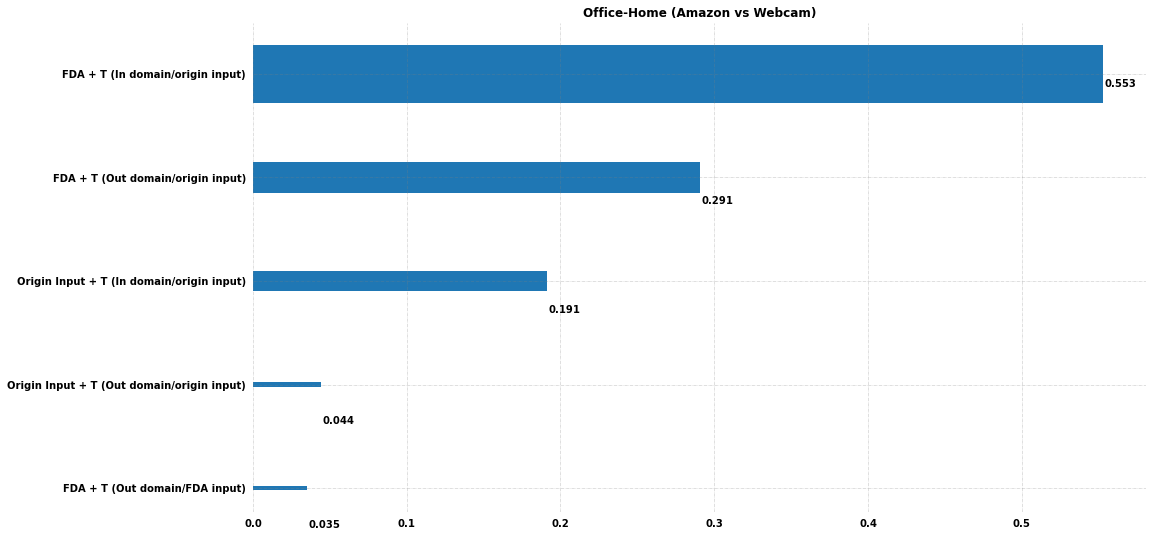

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

name = [
    "FDA + T (In domain/origin input)",
    "FDA + T (Out domain/origin input)",
    "Origin Input + T (In domain/origin input)",
    "Origin Input + T (Out domain/origin input)",
    "FDA + T (Out domain/FDA input)",
]
price_1 = [0.553, 0.291, 0.191, 0.044, 0.035]
price_2 = [0.553, 0.291, 0.191, 0.044, 0.035]

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))

# Horizontal Bar Plot
ax.barh(name, price)

ax.barh(name, price)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
	ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(10)
    label.set_fontweight('bold')

# Add padding between axes and labels
# ax.xaxis.set_tick_params(pad = 5)
# ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.5)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
	plt.text(i.get_width()+0.001, i.get_y()+0.4,
        i.get_width(),
        fontsize = 10, fontweight ='bold',
        color ='black')

# Add Plot Title
ax.set_title('Office-Home (Amazon vs Webcam)', loc ='center', fontweight="bold")


plt.savefig('../../experiments/office_barplot.png')
# Show Plot
plt.show()


In [179]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

name = [
    "FDA + T (In domain/origin input)",
    "FDA + T (Out domain/origin input)",
    "Origin Input + T (In domain/origin input)",
    "Origin Input + T (Out domain/origin input)",
    "FDA + T (Out domain/FDA input)",
]
price_1 = [0.553, 0.291, 0.191, 0.044, 0.035]
price_2 = [0.553, 0.291, 0.191, 0.044, 0.035]

df = pandas.DataFrame(dict(name, price_1, price_2)) 

ind = np.arange(len(df))
width = 0.4

fig, ax = plt.subplots()
ax.barh(ind, df.n, width, color='red', label='N')
ax.barh(ind + width, df.m, width, color='green', label='M')

ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
ax.legend()

plt.show()

TypeError: dict expected at most 1 argument, got 3

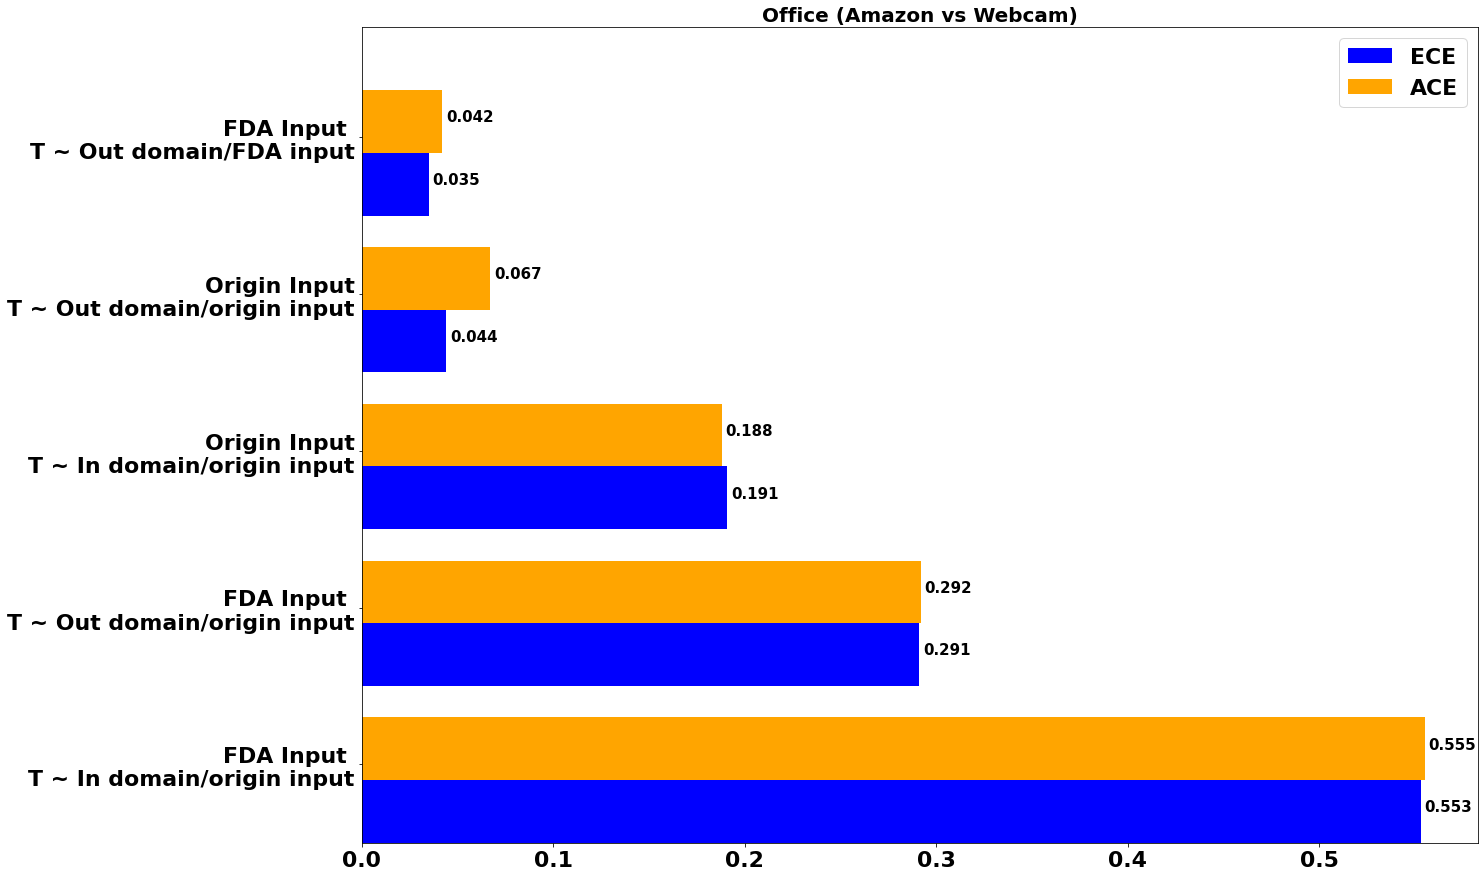

In [277]:
import pandas
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

df = pandas.DataFrame(
    dict(
        name = [
            "FDA Input \nT ~ In domain/origin input",
            "FDA Input \nT ~ Out domain/origin input",
            "Origin Input\nT ~ In domain/origin input",
            "Origin Input\nT ~ Out domain/origin input",
            "FDA Input \nT ~ Out domain/FDA input",
        ],
        price_1 = [0.553, 0.291, 0.191, 0.044, 0.035],
        price_2 = [0.555, 0.292, 0.188, 0.067, 0.042]
    )
) 

ind = np.arange(len(df))
width = 0.4

fig, ax = plt.subplots(figsize=(20, 15))
ax.set_title('Office (Amazon vs Webcam)', fontsize=20, weight="bold")
ax.barh(ind, df.price_1, width, color='blue', label='ECE', align="center")
ax.barh(ind + width, df.price_2, width, color='orange', label='ACE', align="center")
for i in ax.patches:
    plt.text(i.get_width()+0.002, i.get_y() + 0.2,
        i.get_width(),
        fontsize = 15, fontweight ='bold',
        color ='black')

ax.set(yticks=ind + width - 0.1, yticklabels=df.name, ylim=[2*width - 1, len(df)])

ax.legend()
plt.savefig('../../experiments/office_barplot.png', bbox_inches = 'tight')

# plt.show()

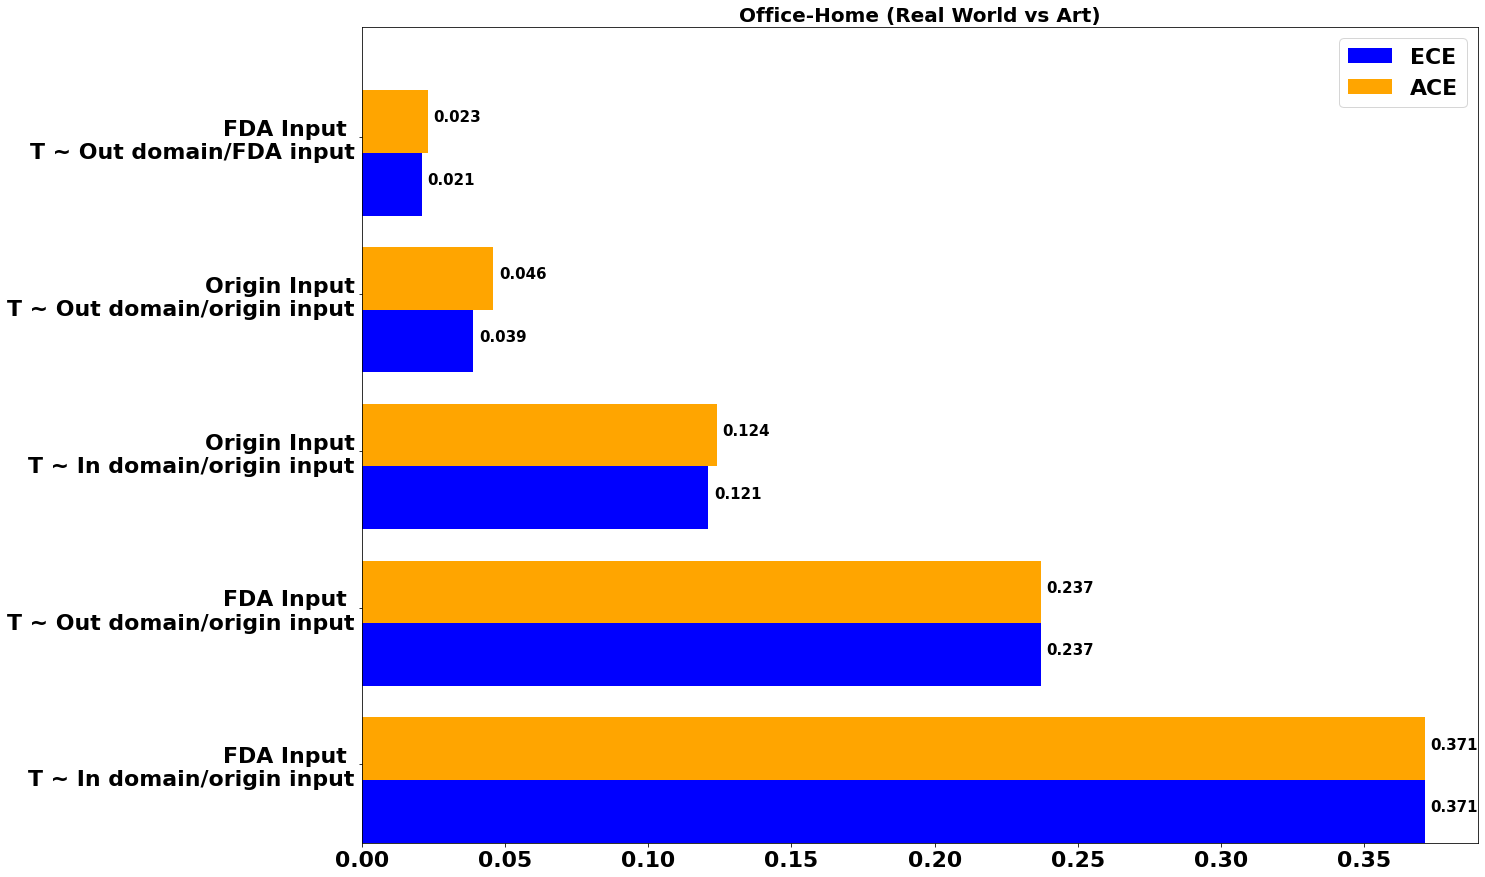

In [278]:
import pandas
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

df = pandas.DataFrame(
    dict(
        name = [
            "FDA Input \nT ~ In domain/origin input",
            "FDA Input \nT ~ Out domain/origin input",
            "Origin Input\nT ~ In domain/origin input",
            "Origin Input\nT ~ Out domain/origin input",
            "FDA Input \nT ~ Out domain/FDA input",
        ],
        price_1 = [0.371, 0.237, 0.121, 0.039, 0.021],
        price_2 = [0.371, 0.237, 0.124, 0.046, 0.023]
    )
) 

ind = np.arange(len(df))
width = 0.4

fig, ax = plt.subplots(figsize=(20, 15))
ax.set_title('Office-Home (Real World vs Art)', fontsize=20, weight="bold")
ax.barh(ind, df.price_1, width, color='blue', label='ECE', align="center")
ax.barh(ind + width, df.price_2, width, color='orange', label='ACE', align="center")
for i in ax.patches:
    plt.text(i.get_width()+0.002, i.get_y() + 0.2,
        i.get_width(),
        fontsize = 15, fontweight ='bold',
        color ='black')

ax.set(yticks=ind + width - 0.1, yticklabels=df.name, ylim=[2*width - 1, len(df)])

ax.legend()
plt.savefig('../../experiments/office_home_barplot.png', bbox_inches = 'tight')

# plt.show()